The idea is to generate some synthetic data according to either a:

1. Autoregressive process of order 1 (AR(1)) with the autoregressive coefficient following a (i) GAS dynamics or a (ii) Sinusodial function or a (iii) Step function.
   
2. Possion process with its parameter that follows, again,  a (i) GAS dynamics or a (ii) Sinusodial function or a (iii) Step function.

In the case (i) the dynamics is said to be well-specified, since what we are going to do is estimating the static parameters of the true underlying dynamics (in other words, we fit on the data the same dynamics that generated the data. Obviously, this is not the common case encountered in empirical studies. Otherwise (case (ii) and (iii), in this example), the dynamics is said to be mis-specified, since we are filtering the true behaviour of our observable via a different dynamics.

The power of the GAS filter lies, in general, in its ability to follow the underlying dynamic, regardless what it is. Hence, it is a good filter of a mis-specified dynamics. It can be proven that it is also optimal in an information-theoretic sense, i.e. it is able to reduce at each time step the Kullback-Leibler divergence between the true probability distribution (unkwnon) and the model implied one.

Note 1: the errors evaluated on the filtered parameter (the autoregressive coefficient or the poisson parameter) differs in the two cases. 
Note 2: in the AR(1), it is possibile also to introduce a link function on the autoregressive coefficient in order to modulate b_t. In what follows we will consider the simplest case with an identity function.

In [1]:
import argparse
import logging
import time

import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from gas import ML_errors, b_error
from regression_parameters import regression
from scipy.optimize import minimize
from scipy.stats import chi2, norm, normaltest, poisson
from scipy.stats import t as t_student
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import warnings

In [5]:
def synt_data(model, dynamics, link_fun, *args, size):
    '''This function generates a variable following an AR(1) process with autoregressive parameter that varies in time in specific ways decided
    by the dynamics argument OR following a Poisson process whose paramter is determined by the dyanamics argument.

    Parameters
    ----------
    model : str
        'autoregressive' or 'poisson'.
    *args : variable number of floats
        Static parameters of the model.
    dynamics : str
        'gas', 'step' or 'sin' decide the dynamics of the autoregressive/poisson parameter.
    size : int
        Lenght of the resulting variable.

    Returns
    -------
    X : ndarray of shape (N)
        Synthetic generated variable.
    b : ndarray of shape (N)
        Time varying parameter.

    '''
    np.random.seed(666)
    X = np.zeros(shape=size)
    b = np.zeros(shape=size)

    if model == 'autoregressive':
        X[1] = np.random.normal(0, sgm)

        for t in range(1, size - 1):
            if dynamics == 'gas':

                if link_fun == 'identity':
                    b[t + 1] = omega + alpha * X[t - 1] * \
                        (X[t] - a - b[t] * X[t - 1]) / sgm**2 + beta * b[t]

                if link_fun == 'logistic':
                    b[t + 1] = omega + alpha * (X[t] - 1 / (1 + np.exp(-b[t])) *
                                                X[t - 1]) * np.exp(-b[t]) / (1 + np.exp(-b[t]))**2 * X[t - 1] / sgm**2 + beta * b[t]

                if link_fun == 'identity_student':
                    b[t + 1] = omega + alpha * (lam + 1) * X[t - 1] * (X[t] - a - b[t] * X[t - 1])  / (lam + (X[t] - a - b[t] * X[t - 1])**2) + beta * b[t]

            if dynamics == 'sin':
                b[t + 1] = 0.5 * np.sin(np.pi * (t + 1) / int(size / 10))

            if dynamics == 'step':
                b[:2] = 0.1
                if (t < 300):
                    b[t + 1] = 0.1
                if (t >= 300):
                    b[t + 1] = 0.5
                if (t >= 600):
                    b[t + 1] = 0.1

            if link_fun == 'logistic':
                X[t + 1] = a + 1 / (1 + np.exp(-b[t + 1])) * \
                    X[t] + np.random.normal(0, sgm)

            if link_fun == 'identity':
                X[t + 1] = a + b[t + 1] * X[t] + np.random.normal(0, sgm)

            if link_fun == 'identity_student':
                X[t + 1] = a + b[t + 1] * X[t] + t_student.rvs(lam)

    if model == 'poisson':
        X[0] = np.random.poisson(b[0])

        for t in range(size - 1):

            if dynamics == 'gas':
                b[t + 1] = omega + alpha * \
                    (X[t] - np.exp(b[t])) * (np.exp(b[t])) + beta * b[t]

            if dynamics == 'sin':
                b[t + 1] = 0.5 * np.sin(np.pi * (t + 1) / int(size / 10))

            if dynamics == 'step':
                if t < 300:
                    b[t + 1] = 0.1
                if t >= 300:
                    b[t + 1] = 0.5
                if t >= 600:
                    b[t + 1] = 0.1

            X[t + 1] = np.random.poisson(np.exp(b[t + 1]))

    return X, b

For instance, we can look at some of these generated data. Starting with the AR(1)

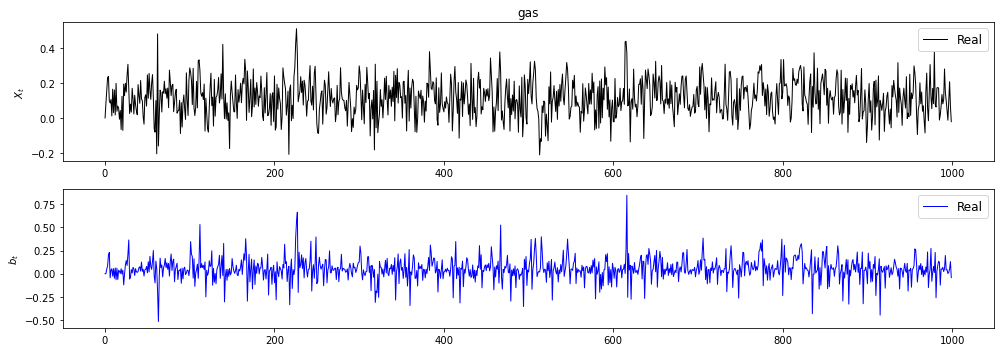

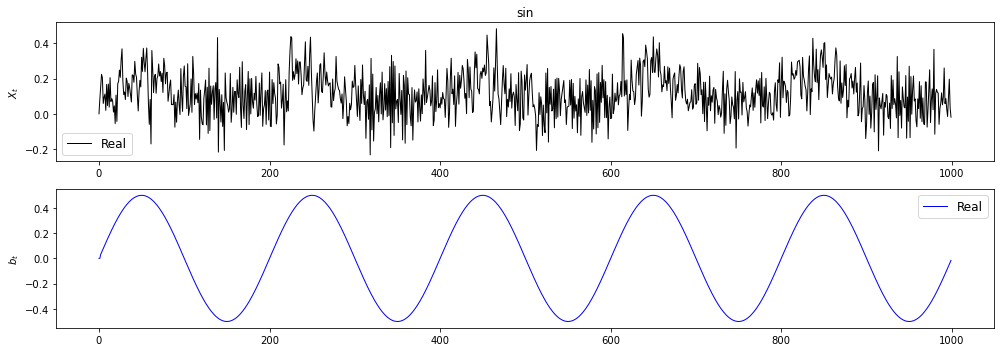

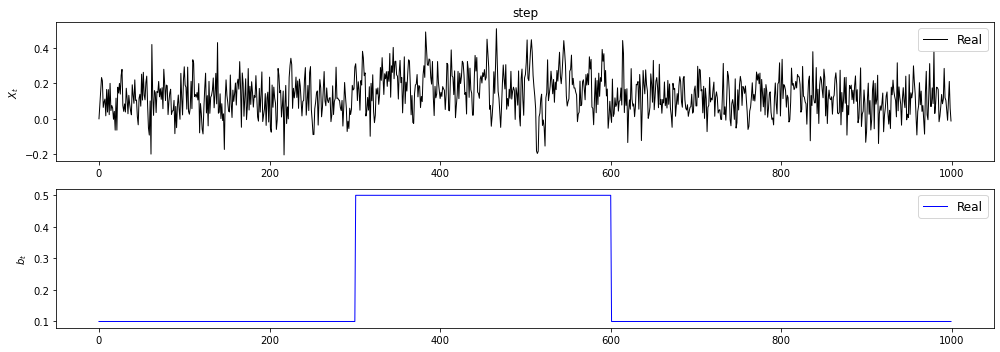

In [9]:
n = 1000
model = 'autoregressive'

# Static parameters
omega = 0.05
alpha = 0.08
beta = 0.06
sgm = 0.1
a = 0.1

for d in ['gas', 'sin', 'step']:
    X, b = synt_data(model, d, 'identity', omega, alpha, beta, sgm, size=n)

    fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(14, 5))
    axs[0].set_title(f'{d}')
    axs[0].plot(X[:n], 'k', label='Real', linewidth=1)
    axs[1].plot(b[:n], 'b', label='Real', linewidth=1)
    axs[0].set_ylabel(r'$X_t$')
    axs[1].set_ylabel(r'$b_t$')
    axs[0].legend(fontsize=12)
    axs[1].legend(fontsize=12)
    plt.show()

And now the Poisson case

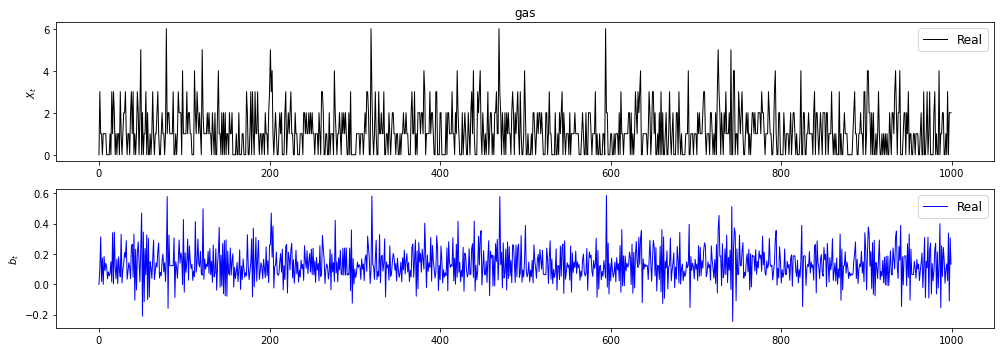

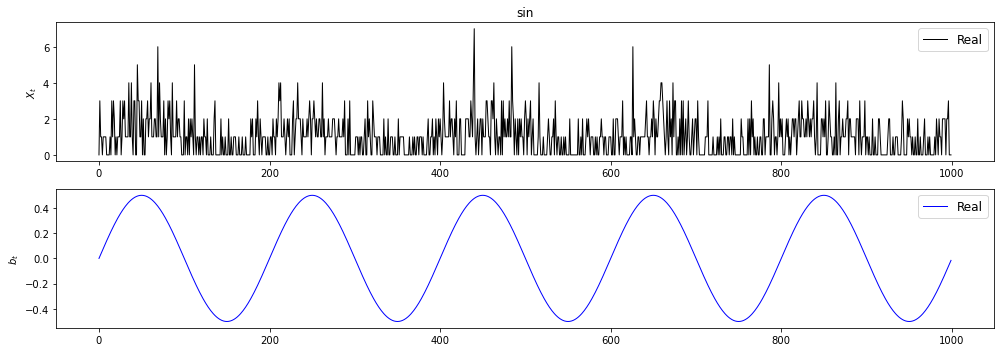

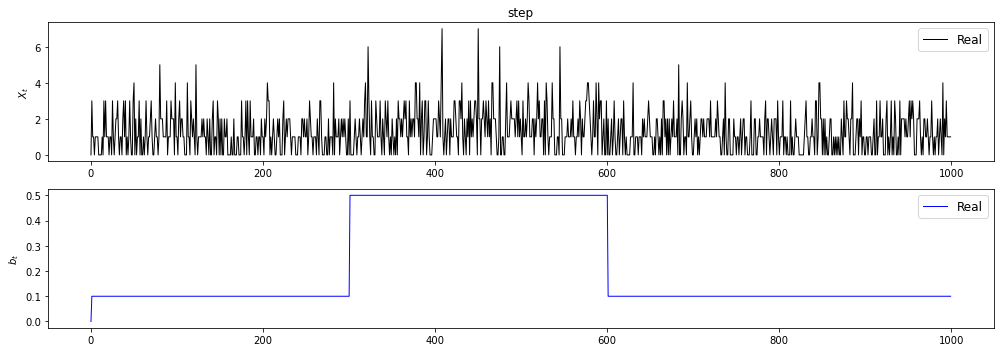

In [10]:
model = 'poisson'

# Static Parameters
alpha = 0.081
beta = -0.395
omega = 0.183

for d in ['gas', 'sin', 'step']:
    X, b = synt_data(model, d, 'identity', omega, alpha, beta, sgm, size=n)

    fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(14, 5))
    axs[0].set_title(f'{d}')
    axs[0].plot(X[:n], 'k', label='Real', linewidth=1)
    axs[1].plot(b[:n], 'b', label='Real', linewidth=1)
    axs[0].set_ylabel(r'$X_t$')
    axs[1].set_ylabel(r'$b_t$')
    axs[0].legend(fontsize=12)
    axs[1].legend(fontsize=12)
    plt.show()

In general, what we see in real application is just the observable X_t. We do not known how the time-varying parameter varies, but we want to filter it via GAS models.

So, now that we have generated these data, we want to check the goodness of these GAS models. Therefore, we estimate the values of the static parameters from the synthetic time-series via Maximum Likelihood and compare them with the real ones.

Regardless what is the true underlying dynamics of our time-varying paramater, we filter it with a GAS model.

We have to (a) evaluate the likelihood function (actually its logarithm) and (b) maximize it according to the static paramters.

In [13]:
def model_loglikelihood(params, X, model, link_fun):
    '''This function computes the total loglikelihood of the AR(1) model with GAS(1,1) filter on the autoregressive/poisson parameter. 
    In the autoregressive case, the innovation is assumed to be normally distributed.

    Parameters
    ---------
    params : list
        Static parameters of the model.
    X : ndarray
        AR(1) of poisson variable generated by the synt_data function.
    model : str
        'autoregressive' or 'poisson'.

    Returns
    -------
    loglikelihood : ndarray of shape (X.shape[0])
        Total loglikehood with opposite sign divided by the length of the sample.
    '''

    T = X.shape[0]
    b = np.zeros_like(X)

    if model == 'autoregressive':
        a, omega, alpha, beta, sgm = params
        for t in range(1, T - 1):
            if link_fun == 'identity':
                b[t + 1] = omega + alpha * \
                    (X[t] - a - b[t] * X[t - 1]) * X[t - 1] / sgm**2 + beta * b[t]

            if link_fun == 'logistic':
                b[t + 1] = omega + alpha * (X[t] - a - 1 / (1 + np.exp(-b[t])) *
                                            X[t - 1]) * np.exp(-b[i]) / (1 + np.exp(-b[t]))**2 * X[t - 1] / sgm**2 + beta * b[t]

            if link_fun == 'identity_student':
                b[t + 1] = omega + alpha * (lam + 1) * X[t - 1] * (X[t] - a - b[t] * X[t - 1])  / (lam + (X[t] - a - b[t] * X[t - 1])**2) + beta * b[t]

        sum = 0
        for i in range(T - 1):
            if link_fun == 'identity':
                sum += - 0.5 * np.log(2 * np.pi * sgm**2) - 0.5 / \
                    sgm**2 * (X[i + 1] - a - b[i + 1] * X[i])**2

            if link_fun == 'logistic':
                sum += - 0.5 * np.log(2 * np.pi * sgm**2) - 0.5 / \
                    sgm**2 * (X[i + 1] - a - 1 / (1 + np.exp(-b[i + 1])) * X[i])**2

            if link_fun == 'identity_student':
                sum += - (lam + 1) * 0.5 * np.log(1 + (X[i + 1] - a - b[i + 1] * X[i])**2 / lam)

    if model == 'poisson':
        alpha, beta, omega = params
        for t in range(T - 1):
            b[t + 1] = omega + alpha * \
                (X[t] - np.exp(b[t])) * (np.exp(b[t])) + beta * b[t]

        sum = 0
        for t in range(T):
            sum = sum + poisson.logpmf(X[t], mu=np.exp(b[t]))

    loglikelihood = - sum / T
    
    return loglikelihood

In [14]:
def model_estimation(X, model, link_fun, specification):
    '''Compute the fixed parameters estimation of the AR(1) model with a GAS(1,1) filter of the autoregressive/poisson parameter. 
    This function uses the output of model_loglikelihood and it is based on the minimize module of scipy.optimize.
    The specification argument modules the way errors are computed.

    Paramters
    ---------
    X : ndarray
        AR(1) of poisson variable generated by the synt_data function.
    model : str
        'autoregressive' or 'poisson'.
    link_fun : str
        'identity' or 'logistic'.
    specification : str
        'mis' for mis-specified, 'correct' for correct specified.

    Returns
    -------

    b : numpy ndarray
        Filterd dynamics of the autoregressive/poisson parameter.
    res : numpy ndarray
        Scipy.optimize.minimize results.
    xi : numpy ndarray
        Filtered residuals.
    std_err : numpy ndarray
        Errors of the static paramter.
    std_b : float
        Error on the filterd autoregressive/poisson parameter.
    init_params : list of floats
        Initial guess.
    '''
    if model == 'autoregressive':
        num_par = 5
    if model == 'poisson':
        num_par = 3

     # This is the "tricky" part. I found that the estimation was greatly influenced by the starting point. Therefore, on different runs
    # I got different estimates. In order to stabilize them, I start different estimations from different initial guesses. Then, I choose the
    # best one according to the least value of -log(L) and, starting from that point I perform another run of the optimization. Finally,
    # from this last estimate, I perform a BFGS optimization for just one step in order to have the approximation of the Hessian and
    # Jacobian function.
    res_iter = np.zeros(shape=(13, num_par + 1))

    for i in range(res_iter.shape[0]):
        init_params = np.random.uniform(0, 1, size=num_par)
        res = minimize(model_loglikelihood, init_params,
                       (X, model, link_fun), method='Nelder-Mead')

        if np.isnan(res.fun) == False:
            res_iter[i, :-1] = res.x
            res_iter[i, -1] = res.fun

    init_params = res_iter[np.where(
        res_iter[:, -1] == res_iter[:, -1].min())][0][:-1]

    res = minimize(model_loglikelihood, init_params,
                   (X, model, link_fun), method='Nelder-Mead')

    # From the final estimate I perform just one step of the BFGS algorithm in order to have the approximation of the Hessian and Jacobain
    # functions needed to compute the errors.
    res = minimize(model_loglikelihood, res.x, (X, model, link_fun),
                   method='BFGS', options={'maxiter': 1})

    estimates = res.x
    
    # Errors on the estimates. The 'specification' parameter can be 'mis' (mis-specified) or 'correct' (well-specified). As written in Note 1, the errors depends
    # on how the dynamics is. 
    std_err = ML_errors(res.jac, res.hess_inv, estimates, X, specification)

    # Error on the filtered time-varying parameter.
    std_b = b_error(X, res, 2000, model, link_fun, specification)

    T = X.shape[0]
    b = np.zeros_like(X)
    xi = np.zeros_like(b)

    if model == 'autoregressive':
        a, omega, alpha, beta, sgm = estimates

        for t in range(1, T - 1):
            if link_fun == 'identity':
                b[t + 1] = omega + alpha * X[t - 1] * \
                    (X[t] - a - b[t] * X[t - 1]) / sgm**2 + beta * b[t]
                xi[t + 1] = X[t + 1] - a - b[t + 1] * X[t]

            if link_fun == 'logistic':
                b[t + 1] = omega + alpha * (X[t] - a - 1 / (1 + np.exp(-b[t])) *
                                            X[t - 1]) * np.exp(-b[t]) / (1 + np.exp(-b[t]))**2 * X[t - 1] / sgm**2 + beta * b[t]
                xi[t + 1] = X[t + 1] - a - 1 / (1 + np.exp(-b[t + 1])) * X[t]

            if link_fun == 'identity_student':
                b[t + 1] = omega + alpha * (lam + 1) * X[t - 1] * (X[t] - a - b[t] * X[t - 1]) / (lam + (X[t] - a - b[t] * X[t - 1])**2) + beta * b[t]
                xi[t + 1] = X[t + 1] - a - b[t + 1] * X[t]


    if model == 'poisson':
        alpha, beta, omega = estimates
        xi = 0

        for t in range(T - 1):
            b[t + 1] = omega + alpha * \
                (X[t] - np.exp(b[t])) * (np.exp(b[t])) + beta * b[t]

        B_T = omega + alpha * (X[-1] - np.exp(b[-1])) * \
            (np.exp(b[-1])) + beta * b[-1]

    if link_fun == 'logistic': b = 1 / (1 + np.exp(-b))

    return b, res, xi, std_err, std_b, init_params

In [15]:
model = 'autoregressive'
dynamics = 'sin'
sgm = 0.1
specification = 'mis'

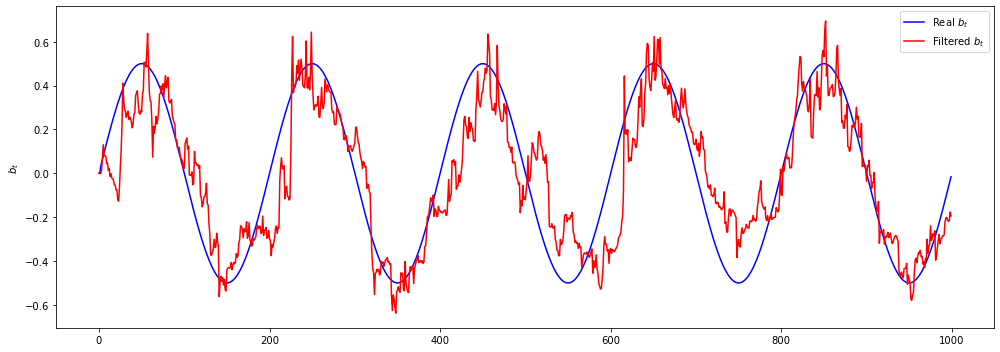

In [18]:
# Ignore runtime warnings. They are returned due to overflows or invalid operations. 
# These situations are caused by the evaluations during the optimization procedure. They do not necessarly mean that the estimation fails.
warnings.filterwarnings('ignore')

X, b = synt_data(model, dynamics, 'identity', sgm, size=n)
B, res, xi, std_err, std_b, init_params = model_estimation(X, model, 'identity', specification)

plt.figure(figsize=(14,5), tight_layout=True)
plt.plot(b, 'b', label=r'Real $b_t$')
plt.plot(B, 'red', label=r'Filtered $b_t$')
plt.legend()
plt.ylabel(r'$b_t$')
plt.show()

As I already said, the errors on the filtered b_t depends on the specification of the dynamics. You can find more details in 

Blasques F, Koopman S.J., Lasak K., Lucas A., "In-sample confidence bands and out-of-sample forecast bands for time-varying parameters in observation-driven models" International Journal of Forecasting, Vol. 32, 2016, 875–887.

Anyway, I always found that the errors in the mis-specified case were extremely small due to the fact that you have to compute the product of the I x J x I where I is the inverse of the Fisher information matrix and J the direct product of the Jacobian with itselft. I do not know if and what is the problem. In the well-specified case, the error is quite reasonable.